# Deblending with *Scarlet*
<br>Owner(s): **Fred Moolekamp** ([@fred3m](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@fred3m))
<br>Last Verified to Run: **2019-08-16**
<br>Verified Stack Release: **w_2019-31**

The purpose of this tutorial is to familiarize you with the basics of using *scarlet* to model blended scenes, and how tweaking various objects and parameters affects the resulting model. A tutorial that is more specific to using scarlet in the context of the LSST DM Science Pipelines is also available.

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Configure and run _scarlet_ on a test list of objects;
2. Understand its various model assumptions and applied constraints.

Before attempting this tutorial it will be useful to read the [introduction](https://fred3m.github.io/scarlet/user_docs.html) to the *scarlet* User Guide, and many of the exercises below may require referencing the *scarlet* [docs](https://fred3m.github.io/scarlet/).

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

In [108]:
# What version of the Stack are we using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-imendoza-w-2020-24
lsst_distrib          19.0.0-1-gc154f85+75 	current w_2020_24 setup


In [109]:
# Import the necessary libraries
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# don't interpolate the pixels
matplotlib.rc('image', interpolation='none')

import numpy as np
from astropy.visualization.lupton_rgb import AsinhMapping

import scarlet
import scarlet.display
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping

# Display functions

Below are several useful functions used throughout this tutorial to visualize the data and models.

In [145]:
def show_psfs(psfs, filters, norm=None):
    rows = int(np.ceil(len(psfs)/3))
    columns = min(len(psfs), 3)
    figsize = (45/columns, rows*5)
    fig = plt.figure(figsize=figsize)
    ax = [fig.add_subplot(rows, columns, n+1) for n in range(len(psfs))]
    for n, psf in enumerate(psfs):
        im = ax[n].imshow(psf, norm=norm)
        ax[n].set_title("{0}-band PSF".format(filters[n]))
        plt.colorbar(im, ax=ax[n])
    plt.show()

def display_diff_kernels(psf_blend, diff_kernels):
    model = psf_blend.get_model()
    for b, component in enumerate(psf_blend.components):
        fig = plt.figure(figsize=(15,2.5))
        ax = [fig.add_subplot(1,4,n+1) for n in range(4)]
        # Display the psf
        ax[0].set_title("psf")
        _img = ax[0].imshow(psfs[b])
        fig.colorbar(_img, ax=ax[0])
        # Display the model
        ax[1].set_title("modeled psf")
        _model = np.ma.array(model[b], mask=model[b]==0)
        _img = ax[1].imshow(_model)
        fig.colorbar(_img, ax=ax[1])
        # Display the difference kernel
        ax[2].set_title("difference kernel")
        _img = ax[2].imshow(np.ma.array(diff_kernels[b], mask=diff_kernels[b]==0))
        fig.colorbar(_img, ax=ax[2])
        # Display the residual
        ax[3].set_title("residual")
        residual = psfs[b]-model[b]
        vabs = np.max(np.abs(residual))
        _img = ax[3].imshow(residual, vmin=-vabs, vmax=vabs, cmap='seismic')
        fig.colorbar(_img, ax=ax[3])
        plt.show()

# Load and Display the data

The `file_path` points to a directory with 147 HSC blends from the COSMOS field detected by the LSST pipeline. Changing `idx` below will select a different blend.

Background RMS: [0.04287751 0.06435928 0.10105371 0.17749543 0.18650883]


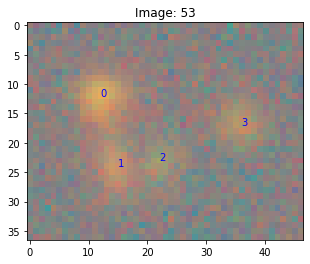

In [111]:
# Load the sample images
idx = 53
file_path = "/project/shared/data/testdata_deblender/real_data/hsc_cosmos/not_matched"
files = os.listdir(file_path)
data = np.load(os.path.join(file_path, files[idx]))
images = data["images"]
weights = data["weights"]
peaks = data["peaks"]
psfs = data["psfs"]
filters = ["G", "R", "I", "Z", "Y"]

# Only a rough estimate of the background is needed
# to initialize and resize the sources
bg_rms = np.std(images, axis=(1,2))
print("Background RMS: {0}".format(bg_rms))

# Use Asinh scaling for the images
norm = AsinhMapping(minimum=images.min(), stretch=images.max()/20, Q=10)

# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
plt.title("Image: {0}".format(idx))
for k, src in enumerate(peaks):
    plt.text(src[0], src[1], str(k), color="blue")
plt.show()

## Psf display 

We can also takea  look at the `psfs`

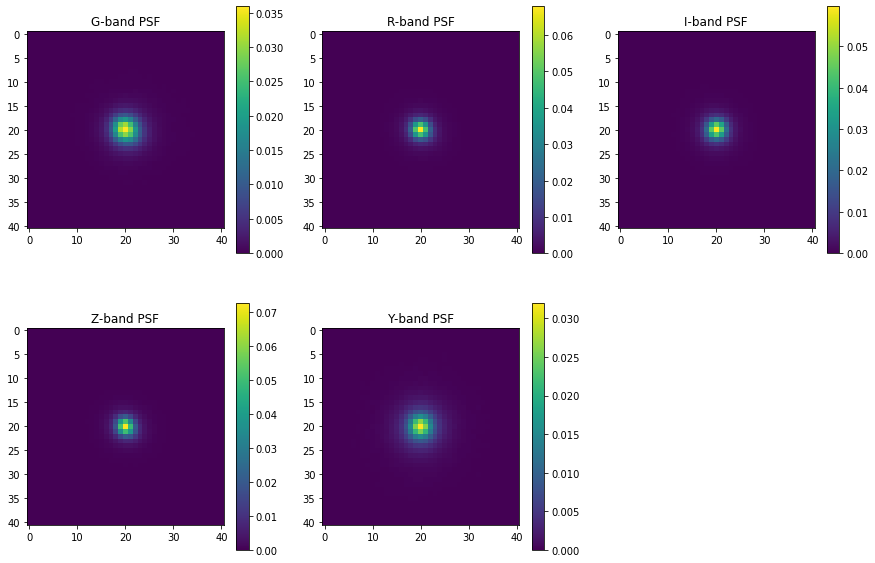

In [144]:
show_psfs(psfs, filters)

# Define the model and observation frames

A `Frame` in scarlet is the metadata that defines the hyperspectral data cube, including dimensions, wcs (optional), and the PSF (technically optional but recommended). So we need to define a frame for our model and for the `Observation`, which contains the image and variance data for the observations of the scene that we are deblending. In scarlet it is possible to deblend scenes that have observations with different instruments that have different resolutions and/or observations that have not been coadded, however that is outside the scope of this tutorial and the interested reader should be referred to https://fred3m.github.io/scarlet/tutorials/multiresolution.html.

So we will create an initial model `Frame` that uses a narrow gaussian PSF and an `Observation` that consists of multiple bands of an HSC coadded image.

See https://fred3m.github.io/scarlet/user_docs.html#Frame-and-Observation for more on `Frame`s and `Observation`s.

In [112]:
from functools import partial

In [113]:
# Create a PSF image of a narrow gaussian to use as our image PSF
amplitude=1.
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=0.9), shape=(None,41, 41)).image * amplitude
model_psf /= model_psf.sum()
# Make sure that the observation PSF is normalized (otherwise the scaling in PSF matching might be off)
psfs = psfs / psfs.sum(axis=(1, 2))[:, None, None]

# Create the initial frame (metadata for the model).
# Note that we initialized a PSF with shape (Ny, Nx) but a frame
# expects a PSf with shape (bands, Ny, Nx), so we have to
# broadcast the model_psf into an extra dimension
frame = scarlet.Frame(images.shape, psfs=model_psf, channels=filters)

# Create our observation
observation = scarlet.Observation(images, psfs=psfs, channels=filters, weights=weights).match(frame)

# Initializing Sources

Astrophysical objects are modeled in scarlet as a collection of components, where each component has a single SED that is constant over it's morphology (band independent intensity). So a single source might have multiple components, like a bulge and disk, or a single component.

The different classes that inherit from `Source` mainly differ in how they are initialized, and otherwise behave similarly during the optimization routine. This section illustrates the differences between different source initialization classes.

### <span style="color:red"> *WARNING* </span>
Scarlet accepts source positions using the numpy/C++ convention of (y,x), which is different than the astropy and LSST stack convention of (x,y).

Below we demonstrate the usage of `ExtendedSource`, which initializes each object as a single component with maximum flux at the peak that falls off monotonically and has 180 degree symmetry.

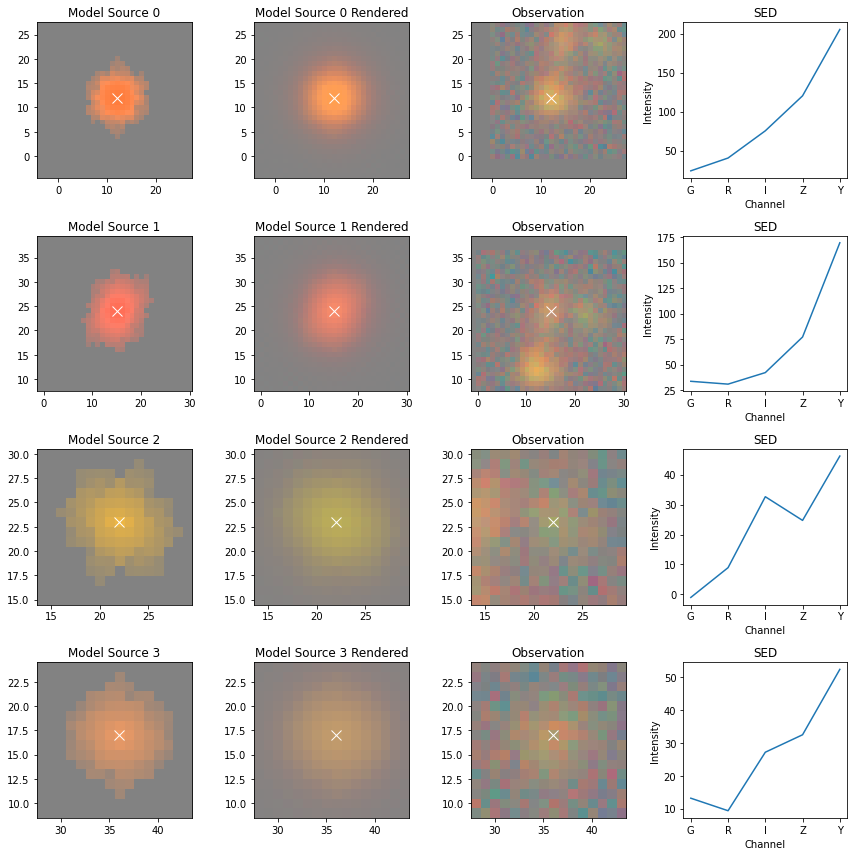

In [114]:
sources = [scarlet.ExtendedSource(frame, (peak[1], peak[0]), observation) for peak in peaks]

# Display the initial guess for each source
scarlet.display.show_sources(sources,
                             norm=norm,
                             observation=observation,
                             show_rendered=True,
                             show_observed=True)
plt.show()

## Exercise:

* Experiment with the above code by using ; and using `MultiComponentSource`, which models a source as two components (a bulge and a disk) that are each symmetric and montonically decreasing from the peak.

# Deblending a scene

The `Blend` class contains the list of sources, the observation(s), and any other configuration parameters necessary to fit the data.

In [115]:
blend = scarlet.Blend(sources, observation)

Next we can fit a model, given a maximum number of iterations and the relative error required for convergence.

CPU times: user 374 ms, sys: 2.04 ms, total: 376 ms
Wall time: 375 ms
scarlet ran for 37 iterations to logL = 7726.973798470312


Text(0, 0.5, 'log-Likelihood')

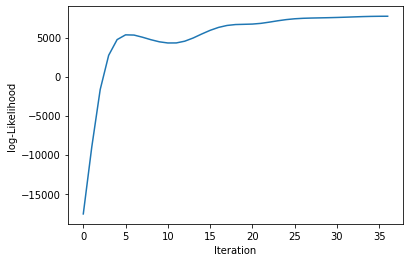

In [116]:
# Fit the data until the relative error is <= 1e-3,
# for a maximum of 200 iterations
blend = scarlet.Blend(sources, observation)
%time blend.fit(200, e_rel = 1e-3)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

There are two options for displaying the scene, using `scarlet.display.show_scene` function. This shows the model along with the observation information and the residuals defined as: `observation.images - model`. 

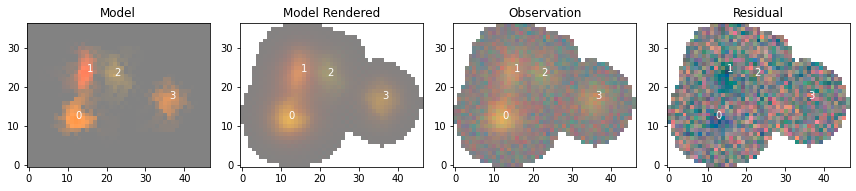

In [140]:
scarlet.display.show_scene(sources, norm=norm,linear=True, 
                           observation=observation, show_observed=True, 
                           label_sources=True, 
                           show_rendered=True, 
                           show_residual=True
                          )
plt.show()

You can also do it by hand. 

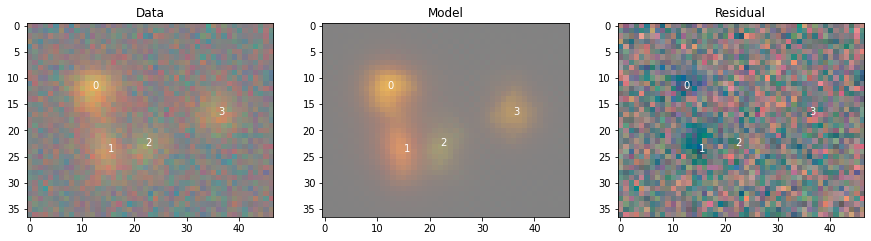

In [141]:
# Load the model and calculate the residual
model = blend.get_model()
model_ = observation.render(model)  # adapt model to observations. 
residual = images-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend):
    y,x = component.center
    ax[0].text(x, y, k, color="w")
    ax[1].text(x, y, k, color="w")
    ax[2].text(x, y, k, color="w")
plt.show()

## Exercises

* Experiment by running the above code using different source models (for example `ExtendedSource`) to see how initializtion affects the belnding results.

# Update Functions

The above models used the default constraints: perfect symmetry and a weighted monotonicity that decreases from the peak. So each source is created with the update function, equivalent to the following:

In [149]:
from scarlet import measure

class MySource(scarlet.ExtendedSource):
    def update(self):
        """Default update parameters for a PointSource
        This method can be overwritten if a different set of constraints
        or update functions is desired.
        """
        # Keep track of the iteration so we can skip certain updates
        # based on the iteration number
        if self._parent is None:
            it = 0
        else:
            it = self._parent.it

        # Update the central pixel location (pixel_center)
        self.pixel_center = measure.max_pixel(self.morph, self.pixel_center)

        if self.symmetric:
            # Update the centroid position every 5th iteration
            if it % 5 == 0:
                self.pixel_center, self.shift = measure.psf_weighted_centroid(self.morph,
                                                                                  self._centroid_weight,
                                                                                  self.pixel_center)
            # make the morphology perfectly symmetric
            update.symmetric(self, algorithm="kspace")

        if self.monotonic:
            # make the morphology monotonically decreasing
            update.monotonic(self, self.pixel_center)

        update.positive(self)  # Make the SED and morph non-negative
        update.normalized(self)  # Use MORPH_MAX normalization
        return self

ImportError: cannot import name 'update' from 'scarlet' (/opt/lsst/software/stack/stack/miniconda3-4.7.12-1a1d771/Linux64/scarlet/lsst-dev-g516ae2b0c8/lib/python/scarlet-1.0-py3.7-linux-x86_64.egg/scarlet/__init__.py)

## Exercises

In the code above modify the `MySource.update` method to use different constraints and run the code block following this cell for the following:

* Add the keyword argument `use_nearest=True` to `update.monotonic` and see how that affects the results.

*  Comment out the lines that set `self.pixel_center` so that positions are not updated and see how that changes the results.

In [148]:
offset = np.random.rand(len(peaks), 2)/2
sources = [MySource(frame, (peak[1]+offset[k][0], peak[0]+offset[k][1]), observation, bg_rms) 
           for k, peak in enumerate(peaks)]
blend = scarlet.Blend(sources, observation)
blend.fit(100, e_rel=1e-3)
print("Deblending completed in {0} iterations".format(blend.it))
display_model_residual(images, blend, peaks, norm)
display_sources(sources, observation, norm)

NameError: name 'MySource' is not defined

# Extra Credit

* Modify `MySource` to create a source that has multiple components. You might want to take a look at [MultiComponentSource](https://github.com/fred3m/scarlet/blob/master/scarlet/source.py#L478) to get an understanding about how to do this, but try your own initialization function.